# Check GPT capability to downscale and reason about physical properties


## 2D Data

Prompt:
You are a hydrodynamics and numerical modelling expert. Areal, depth averaged outputs in 60 sec intervals from a 
DHI MIKE21 FM simulation with the specifications below will be handed to you in raster format where each 
raster corresponds to surface elevation data from a single timestep.
Areal, depth averaged outputs in 60 sec intervals from a MIKE21 FM simulation.

- Basis: MIKE21 FM Simulation

- Domain Dimensions: 1500 x 1500 m
- Raster resolution: 100 m in x and y direction
- Bathymetry: constant -2 m (Base case)
- Time step: 60 seconds
- Total time: 360 seconds

- Initial conditions: 0 m surface elevation, 0 m/s velocity in u and v direction
- Boundary conditions:
    - Downstream: Specified water level of 0 m
    - Upstream: Specified water level of 0.05 m with a sine variation soft start over 900 seconds




In [3]:
import mikeio

fn = "C:\Source\openAI-exploration\MIKE\BedResistance\SimA.m21fm - Result Files\SimA_HD.dfsu"
ds = mikeio.read(fn)
ds

<mikeio.Dataset>
dims: (time:7, element:778)
time: 2014-01-01 00:00:00 - 2014-01-01 06:00:00 (7 records)
geometry: Dfsu2D (778 elements, 443 nodes)
items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Total water depth <Water Depth> (meter)
  2:  U velocity <u velocity component> (meter per sec)
  3:  V velocity <v velocity component> (meter per sec)
  4:  Current speed <Current Speed> (meter per sec)
  5:  Drag coefficient <Undefined> (undefined)

In [8]:
ds_item = 'Surface elevation' # item to select

da = ds[ds_item]
da

<mikeio.DataArray>
name: Surface elevation
dims: (time:7, element:778)
time: 2014-01-01 00:00:00 - 2014-01-01 06:00:00 (7 records)
geometry: Dfsu2D (778 elements, 443 nodes)

In [29]:
# create overset grid with 10x10m resolution
g = da.geometry.get_overset_grid(dx=100)
g

<mikeio.Grid2D>
x: [50, 150, ..., 1450] (nx=15, dx=100)
y: [50, 150, ..., 1450] (ny=15, dy=100)
projection: PROJCS["UTM-32",GEOGCS["Unused",DATUM["UTM Projections",SPHEROID["WGS 1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000],PARAMETER["False_Northing",0],PARAMETER["Central_Meridian",9],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]

In [30]:
# interpolate to overset grid
da_raster = da.interp_like(g)
da_raster

<mikeio.DataArray>
name: Surface elevation
dims: (time:7, y:15, x:15)
time: 2014-01-01 00:00:00 - 2014-01-01 06:00:00 (7 records)
geometry: Grid2D (ny=15, nx=15)

<Axes: xlabel='Easting [m]', ylabel='Northing [m]'>

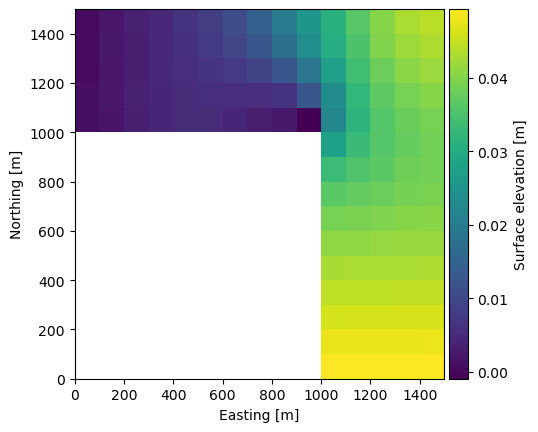

In [31]:
da_raster.sel(time=3).plot()

In [32]:
from numpy import savetxt
for i, time in enumerate(ds.time):
    np_raster = da_raster.sel(time=time).to_numpy()
    savetxt(f'{ds_item}_t{i}.csv', np_raster, delimiter=',')

- physical understanding: current speeds from dynamic surface elevation
- Inference: Are you able to infer the constant bed resistance as manning number? 

## Timeseries

You are a hydrodynamics and numerical modelling expert. If you do not have an answer, reply with "i don't know".

In the following I'll provide you with observed (measured) timeseries from the german Elbe river. 
1. water levels from Stadersand, 
2. Discharge measurements from Neu Darchau and 
3. water level measurements from St. Pauli. 

Based on this, can you find an analytical solution for the water level at St. Pauli given the other two measurements are known?